In [1]:
import os
import datetime

import sys

sys.path.append("..")

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from functions import df_security_code, missingValues



mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Data

In [2]:
data = pd.read_csv('../data/a_price_financial_fill.csv', parse_dates=['Date'],  index_col=[0])
df = df_security_code(data)
del data

In [3]:
df.head(2)

,RowId,Date,SecuritiesCode,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,ad_Open,ad_High,ad_Low,...,margin,profit_ttm,rev_ttm,win_quarter_growth,rev_quarter_growth,win_yoy_growth,rev_yoy_growth,win_ttm_growth,rev_ttm_growth,margin_growth
1994405,20170104_7203,2017-01-04,7203,1.0,NaN,0,-0.016882,7010.0,7103.0,6975.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994406,20170105_7203,2017-01-05,7203,1.0,NaN,0,-0.009957,7090.0,7091.0,7023.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- transform date

In [4]:
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m.%d')

In [5]:
#date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m.%d')
timestamp_s = date_time.map(pd.Timestamp.timestamp)


In [6]:
day = 24*60*60
week = 7*day
month = 30.4167*day
year = (365.2425)*day


#df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
#df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

df['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))


df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of Month signal')

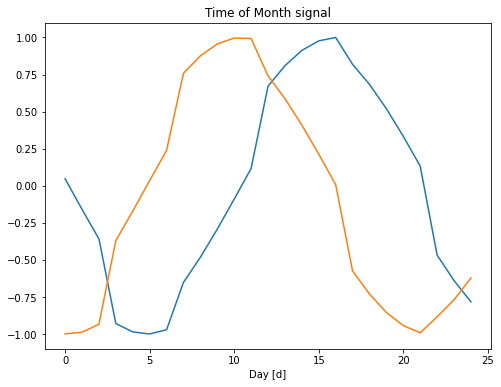

In [7]:
plt.plot(np.array(df['Month_sin'])[:25])
plt.plot(np.array(df['Month_cos'])[:25])
plt.xlabel('Day [d]')
plt.title('Time of Month signal')

In [8]:
feat_to_scale = [col for col in df.columns if col not in ['RowId', 'SecuritiesCode', 'Date', 'Year',
 'week','Date_f_',
 'Day',
 'Month',
 'Year_f_', 'Target','Log_Return',
 'MACD',
 'MACD_h','macd_s',
 'SecuritiesCode_f_']]
#feat_to_scale

# Preparation for modelling

## - Train Test Split


In [9]:
def train_test_split(df, split= 22):
    df.dropna(inplace=True)
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()

    test_data = pd.DataFrame()

    for i in tqdm(df.SecuritiesCode.unique()):
        df_selected = df.query('SecuritiesCode == @i')#.sort_values('Date')
        df_train =  df_selected[:(len(df_selected)-2*split)]
        df_val = df_selected[(len(df_selected)-2*split):(len(df_selected)-split)]
        df_test =  df_selected[(len(df_selected)-split):]

        

        train_data = pd.concat([train_data, df_train])
        val_data = pd.concat([val_data, df_val])
        test_data = pd.concat([test_data, df_test])

    #train_data['Date'] = pd.to_datetime(train_data['Date'])
    #test_data['Date'] = pd.to_datetime(test_data['Date'])

    return train_data, val_data, test_data

In [10]:
train_data, val_data, test_data = train_test_split(df=df)

100%|██████████| 1/1 [00:00<00:00, 178.54it/s]


In [11]:
train_data.head(2)

,RowId,SecuritiesCode,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,ad_Open,ad_High,ad_Low,ad_Close,...,rev_quarter_growth,win_yoy_growth,rev_yoy_growth,win_ttm_growth,rev_ttm_growth,margin_growth,Month_sin,Month_cos,Year_sin,Year_cos
1994674,20180206_7203,7203,1.0,100.0,0,0.024281,7225.0,7310.0,7125.0,7286.0,...,53.594927,40.515906,8.148235,11.731,2.380398,22.343988,-0.467648,-0.883915,0.585497,0.810675
1994675,20180207_7203,7203,1.0,100.0,0,-0.011389,7600.0,7704.0,7350.0,7372.0,...,53.594927,40.515906,8.148235,11.731,2.380398,22.343988,-0.639000,-0.769206,0.599356,0.800483


In [12]:
print(df.shape)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(933, 56)
(889, 56)
(22, 56)
(22, 56)


In [13]:
"""scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[feat_to_scale])
train_scaled = pd.DataFrame(train_scaled)

val_scaled = scaler.fit_transform(val_data[feat_to_scale])
val_scaled = pd.DataFrame(val_scaled)

test_scaled = scaler.fit_transform(test_data[feat_to_scale])
test_scaled = pd.DataFrame(test_scaled)"""

'scaler = StandardScaler()\ntrain_scaled = scaler.fit_transform(train_data[feat_to_scale])\ntrain_scaled = pd.DataFrame(train_scaled)\n\nval_scaled = scaler.fit_transform(val_data[feat_to_scale])\nval_scaled = pd.DataFrame(val_scaled)\n\ntest_scaled = scaler.fit_transform(test_data[feat_to_scale])\ntest_scaled = pd.DataFrame(test_scaled)'

## - Scaling

In [14]:
def scaling_df(df):
    mean_df = df.mean()
    std_df = df.std()
    return  (df - mean_df) / std_df


In [15]:
train_scaled = scaling_df(train_data[feat_to_scale])
val_scaled = scaling_df(val_data[feat_to_scale])
test_scaled = scaling_df(test_data[feat_to_scale])

In [16]:
train_scaled.head(2)

,AdjustmentFactor,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,...,rev_quarter_growth,win_yoy_growth,rev_yoy_growth,win_ttm_growth,rev_ttm_growth,margin_growth,Month_sin,Month_cos,Year_sin,Year_cos
1994674,0.033539,-1.038235,NaN,-0.191241,-0.160796,-0.238308,-0.125728,2.367543,1.621200,0.105240,...,0.38426,-0.084141,-0.111451,0.742216,0.135404,0.581724,-0.642857,-1.268119,0.774432,1.275950
1994675,0.033539,-1.038235,NaN,0.204873,0.254344,0.000816,-0.034710,2.583893,-0.801519,-0.123278,...,0.38426,-0.084141,-0.111451,0.742216,0.135404,0.581724,-0.884130,-1.105330,0.793857,1.261315


? SupervisionFlag NaN ? 

In [17]:
missingValues(test_scaled)

,N_missing,Percentage
AdjustmentFactor,22.0,100.0
ExpectedDividend,22.0,100.0
SupervisionFlag,22.0,100.0


In [18]:
train_data.SupervisionFlag.describe()

count    889.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: SupervisionFlag, dtype: float64

In [19]:
# Supervision flag fill with 0

In [20]:
train_scaled.SupervisionFlag.fillna(0, inplace=True)
val_scaled.SupervisionFlag.fillna(0, inplace=True)
test_scaled.SupervisionFlag.fillna(0, inplace=True)

## - Window

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_scaled, val_df=val_scaled, test_df=test_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
train_scaled.shape

(889, 42)

In [23]:
w1 = WindowGenerator(input_width=22, label_width=1, shift=1,
                     label_columns=['ad_Close'])
w1

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [22]
Label column name(s): ['ad_Close']

In [24]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
example_window = tf.stack([np.array(train_scaled[:w1.total_window_size]),
                           np.array(train_scaled[100:100+w1.total_window_size]),
                           np.array(train_scaled[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

All shapes are: (batch, time, features)
Window shape: (3, 23, 42)
Inputs shape: (3, 22, 42)
Labels shape: (3, 1, 1)


2022-04-27 15:38:57.438319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 15:38:57.439411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
type(example_inputs)

tensorflow.python.framework.ops.EagerTensor

In [27]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-0.64961166]],

       [[-0.19557934]],

       [[-1.05707657]]])>

In [28]:
w1.example = example_inputs, example_labels

In [29]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

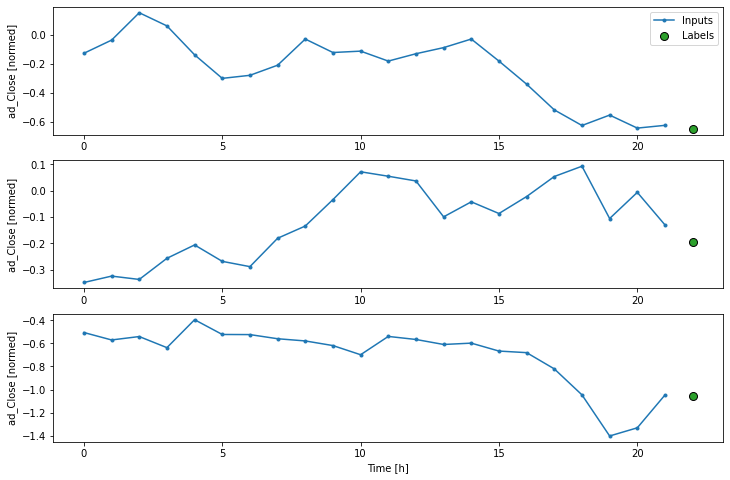

In [30]:
w1.plot()

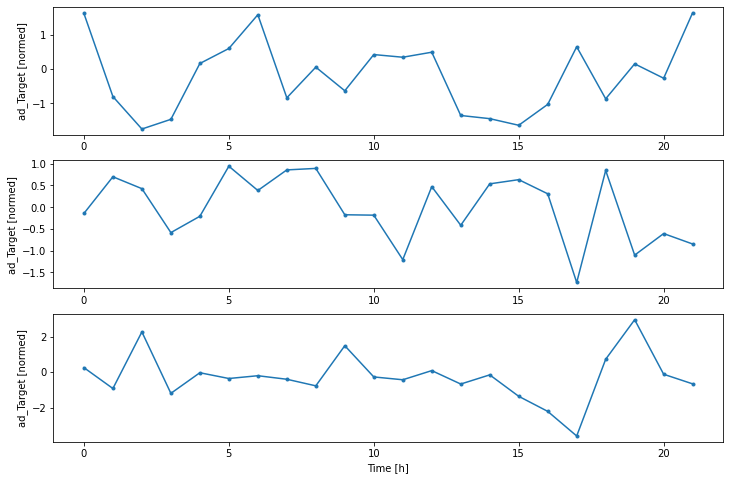

In [31]:
w1.plot(plot_col='ad_Target')

- ## create dataset

In [32]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

## - train , val , test

In [33]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [34]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 22, 42), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [35]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 22, 42)
Labels shape (batch, time, features): (32, 1, 1)


2022-04-27 15:38:58.992610: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## - single step models:
predict a single features value 1 time step into future

In [36]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ad_Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ad_Close']

In [37]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 42)
Labels shape (batch, time, features): (32, 1, 1)


- Baseline

In [38]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [39]:
baseline = Baseline(label_index=w1.column_indices['ad_Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
#val_performance['Baseline'] = baseline.evaluate(w1.val_df)
#performance['Baseline'] = baseline.evaluate(w1.test_df, verbose=0)

1/1 [==============================] - 0s 117ms/step - loss: 0.4067 - mean_absolute_error: 0.5227


2022-04-27 15:38:59.519180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


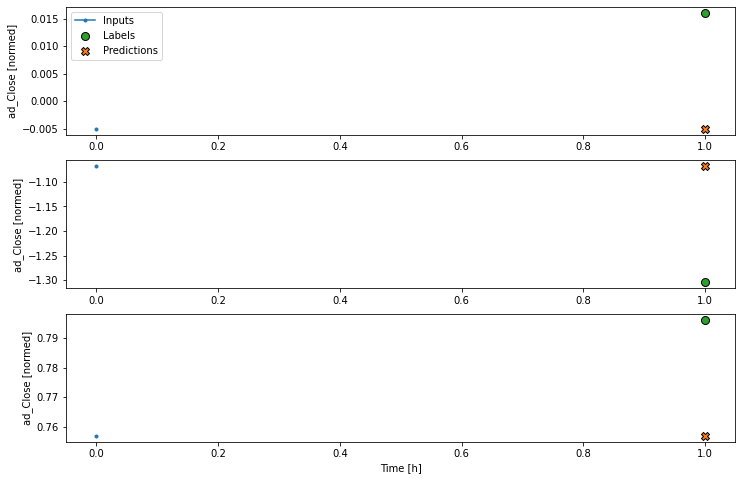

In [40]:
single_step_window.plot(baseline)

In [41]:
wide_window = WindowGenerator(
    input_width=22, label_width=22, shift=1,
    label_columns=['ad_Close'])

wide_window

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Label column name(s): ['ad_Close']

In [42]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 22, 42)
Labels shape (batch, time, features): (32, 22, 1)


In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 22, 42)
Output shape: (32, 22, 1)


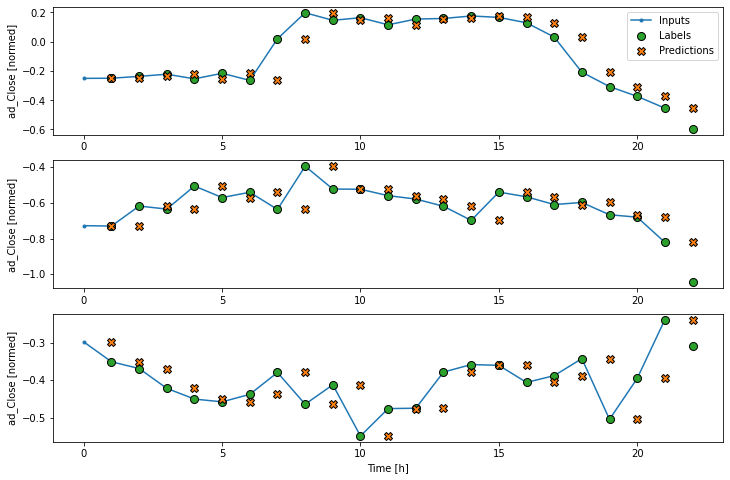

In [44]:
wide_window.plot(baseline)

## - linear

In [45]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [46]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [47]:
history = compile_and_fit(linear, wide_window)

#val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

Epoch 1/20
 9/28 [========>.....................] - ETA: 0s - loss: 0.9136 - mean_absolute_error: 0.7634

2022-04-27 15:39:01.113755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 8ms/step - loss: 0.8473 - mean_absolute_error: 0.7361
Epoch 2/20
28/28 [==============================] - 0s 7ms/step - loss: 0.5849 - mean_absolute_error: 0.6060
Epoch 3/20
28/28 [==============================] - 0s 7ms/step - loss: 0.4153 - mean_absolute_error: 0.5091
Epoch 4/20
28/28 [==============================] - 0s 7ms/step - loss: 0.3036 - mean_absolute_error: 0.4349
Epoch 5/20
28/28 [==============================] - 0s 8ms/step - loss: 0.2298 - mean_absolute_error: 0.3810
Epoch 6/20
28/28 [==============================] - 0s 8ms/step - loss: 0.1808 - mean_absolute_error: 0.3390
Epoch 7/20
28/28 [==============================] - 0s 8ms/step - loss: 0.1467 - mean_absolute_error: 0.3065
Epoch 8/20
28/28 [==============================] - 0s 7ms/step - loss: 0.1210 - mean_absolute_error: 0.2793
Epoch 9/20
28/28 [==============================] - 0s 6ms/step - loss: 0.1017 - mean_absolute_error: 0.2562
Epoch 10/20
28/28 [===========

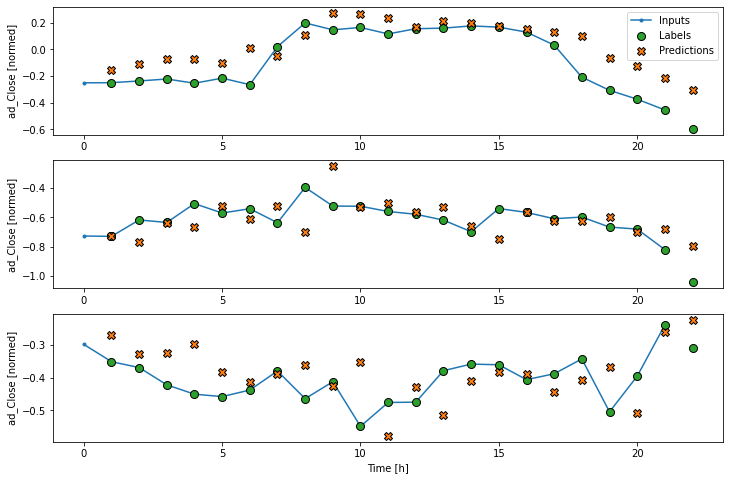

In [48]:
wide_window.plot(linear)

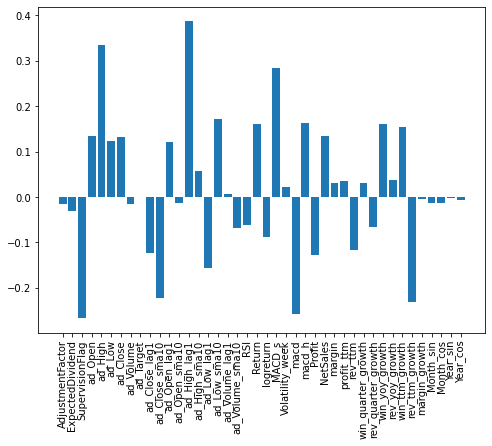

In [49]:
plt.bar(x = range(len(train_scaled.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_scaled.columns)))
_ = axis.set_xticklabels(train_scaled.columns, rotation=90)

In [50]:

#val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

In [51]:
performance

{'Baseline': [0.3727729618549347, 0.5079106688499451], 'Linear': []}

In [52]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

IndexError: list index out of range